# Lightweight Fine-Tuning Project

## Description

* PEFT technique: LoRA 
* Model: [distilbert/distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased)
* Evaluation approach: Hugging Face [Evaluate](https://huggingface.co/docs/evaluate/index) library
* Fine-tuning dataset: [amazon_polarity](https://huggingface.co/datasets/amazon_polarity)

### Hardware:
* CPU: AMD Ryzen 9 7950X3D 16-Core Processor
* GPU: NVIDIA RTX 4070 Ti - 12 GB
* Memory: 64 GB
* OS: Fedora Workstation 39


## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

### Install Dependencies

In [1]:
%pip install --quiet bitsandbytes datasets evaluate ipywidgets matplotlib peft scikit-learn torch transformers transformers[torch]

Note: you may need to restart the kernel to use updated packages.


### Check if GPU is available

In [2]:
import torch
torch.cuda.is_available()

True

### Define Constants

In [3]:
PRETRAINED_MODEL="distilbert-base-uncased"
FINETUNED_MODEL =f"{PRETRAINED_MODEL}-ft-lora"
DATASET="amazon_polarity"



### Download and Import Dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset(DATASET)
dataset["train"][10]

{'label': 0,
 'title': 'The Worst!',
 'content': "A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."}

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

### Load Tokenizer

In [6]:
from transformers import AutoTokenizer, DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(PRETRAINED_MODEL)


def tokenize_function(examples):
    return tokenizer(examples['title'], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(25000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(25000))

### Load Model

In [7]:
from transformers import AutoModelForSequenceClassification

id2label = {
    0:"negative",
    1:"positive"
}
label2id= {
    "negative":0,
    "positive":1
}

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL, 
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Compute Metrics Function
From Hugging Face [Transformers](https://huggingface.co/docs/evaluate/transformers_integrations#trainer) documentation

In [8]:
import numpy as np
import evaluate
# Borrowed from: https://huggingface.co/docs/transformers/training#evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Evaluate pretrained model

In [9]:
from transformers import DataCollatorWithPadding, Trainer


with torch.no_grad():
    pt_evaluate_results = Trainer(
        model = model,
        train_dataset = small_train_dataset,
        eval_dataset = small_eval_dataset,
        tokenizer = tokenizer,
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length"),
        compute_metrics = compute_metrics
    ).evaluate()

/home/jlmayorga/.local/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Pretrained model evaluation results

In [10]:
from pandas import DataFrame

df = DataFrame([pt_evaluate_results])

df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.697832,0.50276,98.6493,253.423,31.678


## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [11]:
model.modules

<bound method Module.modules of DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout):

In [12]:
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    #bias="none",
    target_modules=["q_lin", "v_lin", "classifier"],
    task_type= TaskType.SEQ_CLS,
    #inference_mode= True
)

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 745,746 || all params: 67,706,916 || trainable%: 1.1014325331255672


In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=f"./data", 
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    #auto_find_batch_size=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [14]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length")
)

/home/jlmayorga/.local/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [15]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.481500,0.381422,0.824080
2,0.378600,0.372866,0.830600
3,0.374100,0.369415,0.832440
4,0.368000,0.366919,0.834160
5,0.362600,0.365453,0.835400


TrainOutput(global_step=3910, training_loss=0.3860655528505135, metrics={'train_runtime': 1868.4893, 'train_samples_per_second': 66.899, 'train_steps_per_second': 2.093, 'total_flos': 1.6847156736e+16, 'train_loss': 0.3860655528505135, 'epoch': 5.0})

In [16]:
peft_model.save_pretrained(FINETUNED_MODEL)

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [17]:
from peft import AutoPeftModelForSequenceClassification

trained_model = AutoPeftModelForSequenceClassification.from_pretrained(FINETUNED_MODEL)
trained_model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768

In [18]:
prediction = trainer.predict(small_eval_dataset)
df2=DataFrame([prediction.metrics])
df2

,test_loss,test_accuracy,test_runtime,test_samples_per_second,test_steps_per_second
0,0.365453,0.8354,108.5477,230.314,7.204


In [19]:
import pandas as pd

df2.columns = df.columns
df_combined = pd.concat([df, df2], axis=0, ignore_index=True)
df_combined.insert(0, "Sample", ["Before","After"], True)
df_combined.rename(columns={
    "eval_loss": "Loss", 
    "eval_accuracy": "Accuracy", 
    "eval_runtime": "Runtime", 
    "eval_samples_per_second":"Samples Per Second", 
    "eval_steps_per_second":"Steps Per Second"
}, inplace=True)

df_combined

,Sample,Loss,Accuracy,Runtime,Samples Per Second,Steps Per Second
0,Before,0.697832,0.50276,98.6493,253.423,31.678
1,After,0.365453,0.83540,108.5477,230.314,7.204


<Axes: title={'center': 'LoRA Fine-Tuning Evaluation Results'}, xlabel='Sample'>

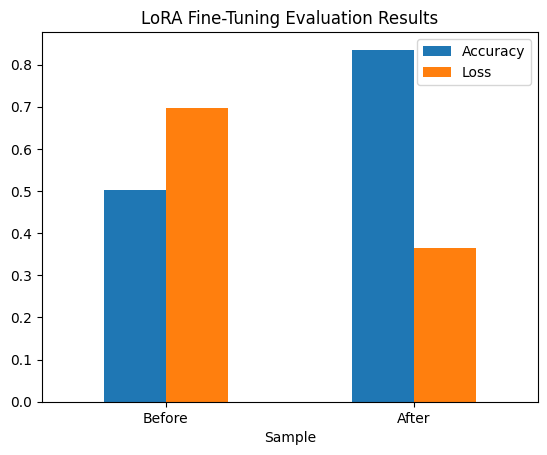

In [20]:
df_combined.plot(
    x="Sample", 
    y=["Accuracy", "Loss"], 
    kind="bar", 
    #subplots=True, 
    title="LoRA Fine-Tuning Evaluation Results",
    rot=0
)

